# SAR Interferometry

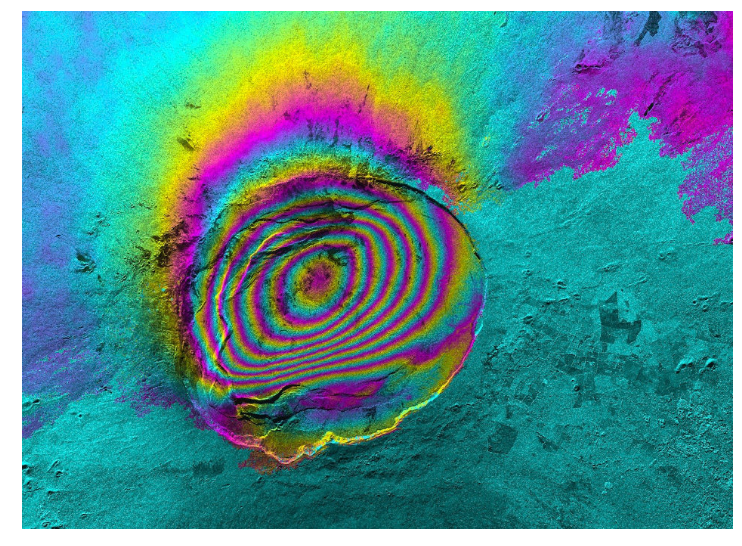

1.  Interferometry is an imaging technique in which waves are superimposed in a manner to cause interference.  
2.   Interferometric synthetic aperture radar (InSAR) techniques combine two or more SAR images over the same region to reveal surface topography or surface motion. 
3. If the combined SAR images originate from slightly different positions, the topography of the surface can be mapped.
4. If images from the same position but taken at different times are combined, the difference between them will show motion, or deformation, of the surface in the time between the two images.
5. The image produced is known as an interferogram. It looks a bit like a rainbow-colored oil slick on the surface of water.



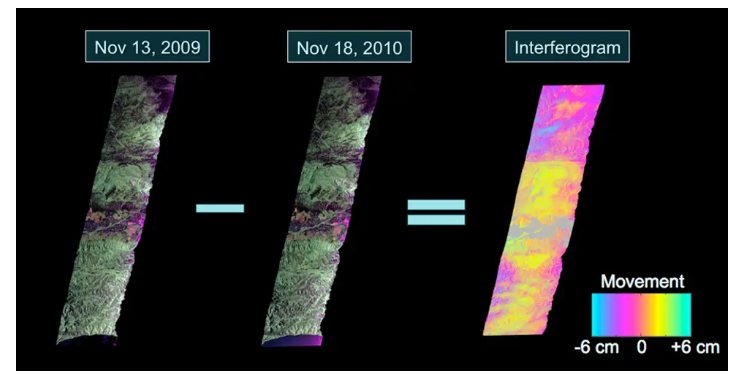

# InSAR (Interferometric Synthetic Aperture Radar)

InSAR measures phase difference between two SAR acquisitions

The interferometric phase, between two SAR images acquired at different times over the same region from the similar viewing geometry, can represent ground movements

The phase difference is equivalent to range change or distance change between radar and target

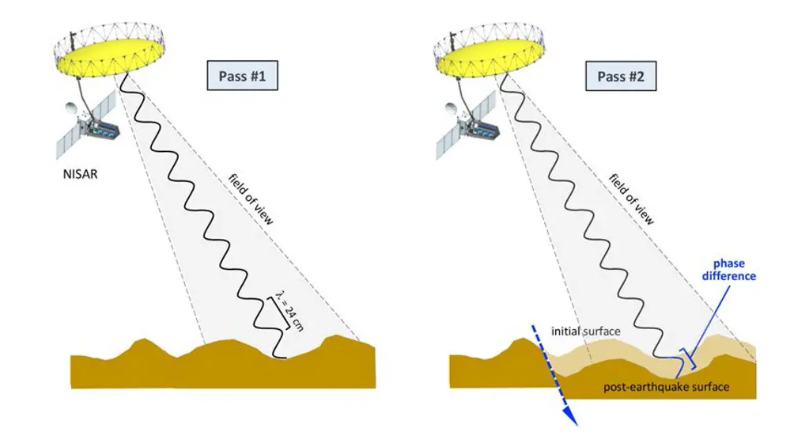

# InSAR Phase Components

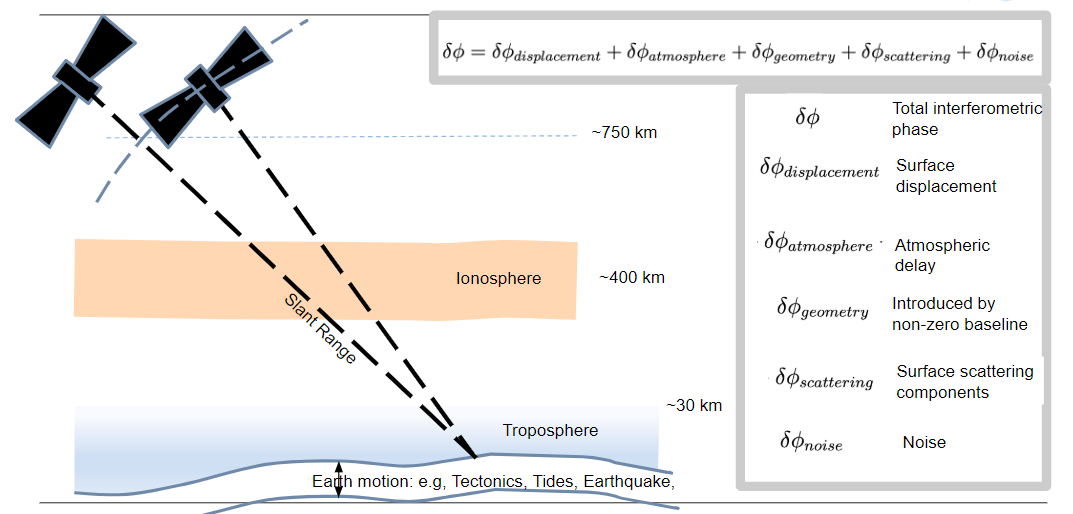

# Why InSAR Time-series analysis?

### a) to reduce the impact of decorrelation
### b) to improve the accuracy of estimated displacement
### c) to understand the temporal evolution of the ground displacement


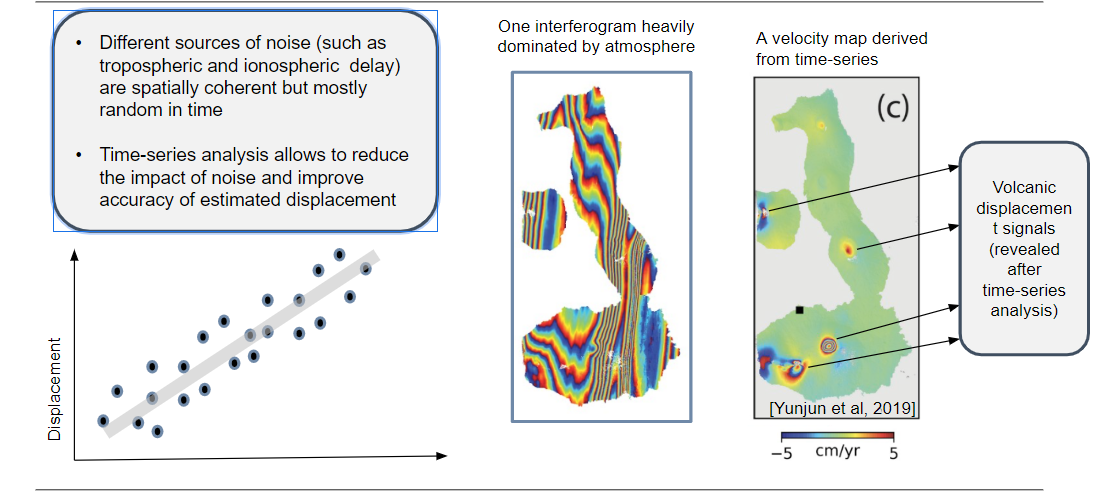

# InSAR Time-series analysis techniques based on types of scatterers


## Type of Scatterers

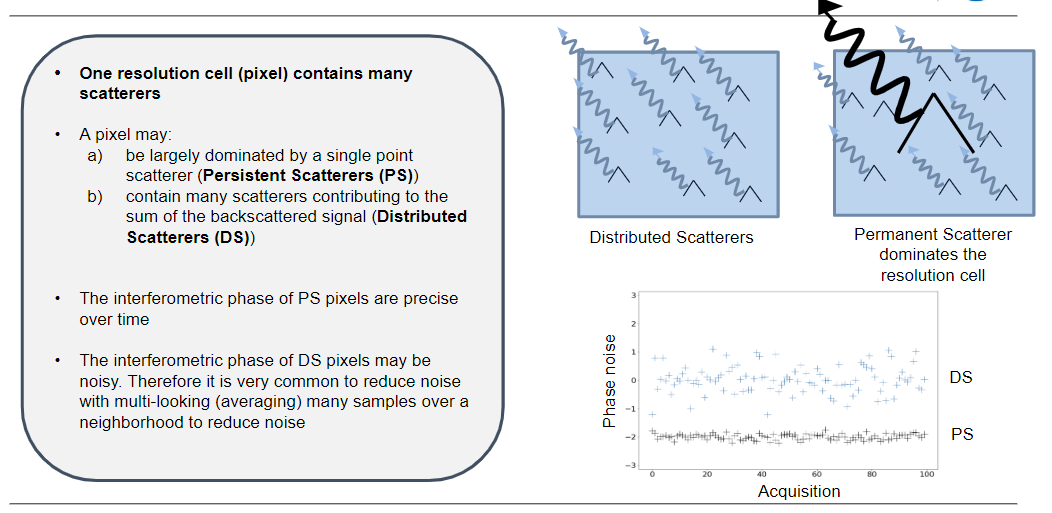

## Distributed Scatterer (DS) time-series analysis


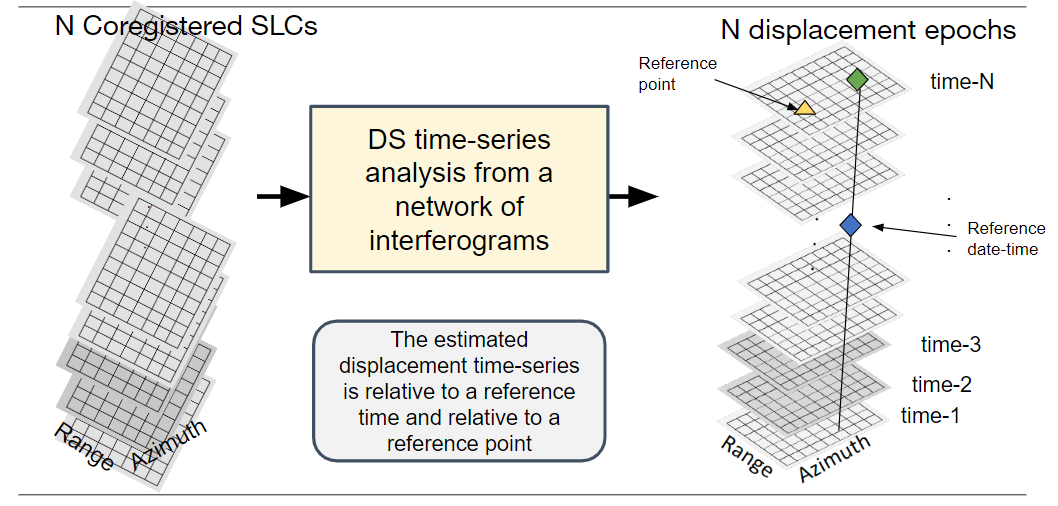

## Distributed Scatterer (DS) time-series analysis algorithms

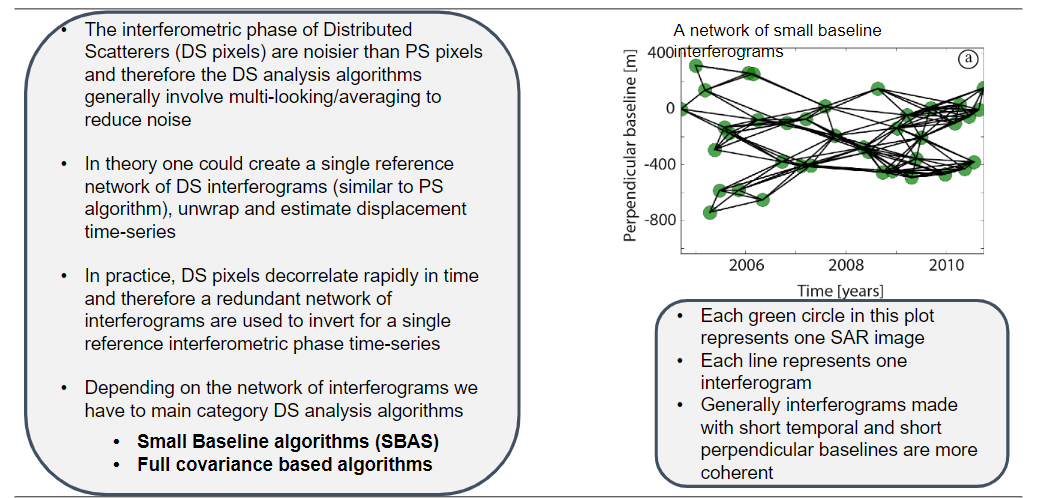

## DS time-series analysis algorithms- Small Baseline algorithms

Taking a coherent network of small baseline interferograms, the Small Baseline Subset (SBAS) algorithms attempt to improve signal to noise ratio in individual interferograms [Berardino et al, 2002]

More coherent interferograms are easier to unwrapping 

The redundant network of unwrapped interferograms are inverted to estimate a singe-reference network of unwrapped interferograms (i.e., the unwrapped phase timeseries)

The estimated unwrapped phase time-series can be converted to range-change time-series (range-change = phase *wavelength/4/PI)

The estimated range change time-series can be post processed to correct for different contributions such as tropospheric delay, DEM errors etc to isolate the displacement time-series signal [Yunjun et al, 2019; Fattahi & Amelung 2013]


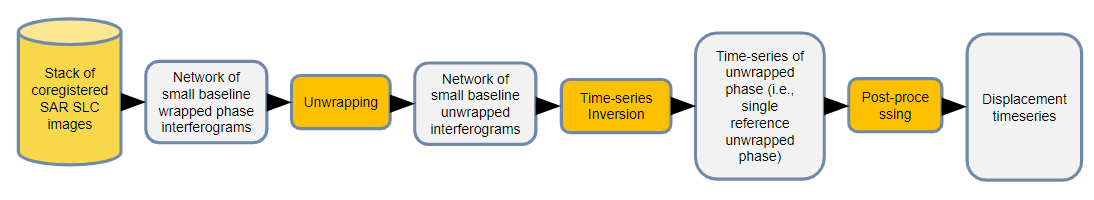

# InSAR Time Series Analysis: MintPy

**The Miami INsar Timeseries software in PYthon** (MintPy) is an open-source package for InSAR time-series analysis. MintPy currently starts from stacks of unwrapped interferograms (in either geo- or radar-coordinates) and estimates ground displacement time-series. MintPy is primarily consistent with stacks of interferograms processed with ISCE. However, the software also supports interfarograms processed with other InSAR processors such as GAMMA, GMTSAR, SNAP and ROI_PAC.

MintPy is available on Github from the following page: https://github.com/insarlab/MintPy

References: The detailed algorithms implemented in MintPy can be found in the following paper:

Yunjun, Z., Fattahi, H., Amelung, F. (2019), Small baseline InSAR time series analysis: Unwrapping error correction and noise reduction, Computers & Geosciences, 133, 104331. [ doi | arxiv | data | notebook ]

## General overview of smallbaselineApp.py

This application provides a workflow which includes several steps to invert a stack of unwrapped interferograms and apply different corrections to obtain ground displacement timeseries. The workflow consists of two main blocks:

1. correcting for unwrapping errors and inverting for the raw phase time-series (blue ovals)
2. correcting for noise from different sources to obtain the displacement time-series (green ovals)

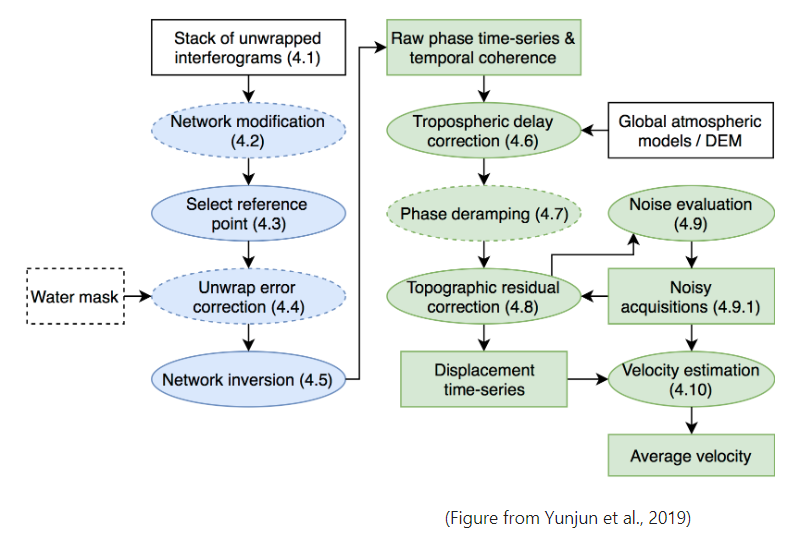

### Processing steps of smallbaselineApp.py

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import mintpy 

from mintpy.cli import view, tsview, plot_network, plot_transection

In [ ]:
!smallbaselineApp.py --help

## Configuring the processing parameters

In [3]:
proj_name = 'RidgecrestSenDT71'
proj_dir = os.path.join('/home/ubuntu/', proj_name)  #Local
hyp3_dir = os.path.join(proj_dir, 'hyp3')
work_dir = os.path.join(proj_dir, 'mintpy')   #Local

In [4]:
def write_config_file(out_file, CONFIG_TXT, mode='a'): 
    """Write configuration files for MintPy to process ARIA sample products"""
    if not os.path.isfile(out_file) or mode == 'w':
        with open(out_file, "w") as fid:
            fid.write(CONFIG_TXT)
        print('write configuration to file: {}'.format(out_file))
    else:
        with open(out_file, "a") as fid:
            fid.write("\n" + CONFIG_TXT)
        print('add the following to file: \n{}'.format(CONFIG_TXT))


In [ ]:
os.chdir(work_dir)
print('Go to work directory: {}'.format(work_dir))

In [ ]:
CONFIG_TXT = f'''# vim: set filetype=cfg:
# vim: set filetype=cfg:
mintpy.compute.cluster      = local
mintpy.load.processor       = hyp3
##---------interferogram datasets:
mintpy.load.unwFile         = {hyp3_dir}/*/*unw_phase_clipped.tif
mintpy.load.corFile         = {hyp3_dir}/*/*corr_clipped.tif
##---------geometry datasets:
mintpy.load.demFile         = {hyp3_dir}/*/*dem_clipped.tif
mintpy.load.incAngleFile    = {hyp3_dir}/*/*lv_theta_clipped.tif
mintpy.load.waterMaskFile   = {hyp3_dir}/*/*water_mask_clipped.tif
##---------subset (optional):
## if both yx and lalo are specified, use lalo option unless a) no lookup file AND b) dataset is in radar coord
mintpy.subset.yx            = auto    #[y0:y1,x0:x1 / no], auto for no
mintpy.subset.lalo          = 391e4:400e4,39e4:51e4    #[S:N,W:E / no], auto for no
mintpy.reference.lalo       = 391.5e4,45e4
mintpy.networkInversion.weightFunc  = no
mintpy.troposphericDelay.method     = pyaps
mintpy.topographicResidual          = yes
mintpy.topographicResidual.stepFuncDate         = 20190706T0320
mintpy.topographicResidual.pixelwiseGeometry    = no
##---------Other:
mintpy.plot = no

'''
print(CONFIG_TXT)
configName = os.path.join(work_dir, "{}.txt".format(proj_name))
write_config_file(configName, CONFIG_TXT, 'w')

In [ ]:
!smallbaselineApp.py  --work-dir {work_dir} {configName} --dostep load_data

In [ ]:
!info.py inputs/geometryGeo.h5

In [ ]:
! ls -l inputs

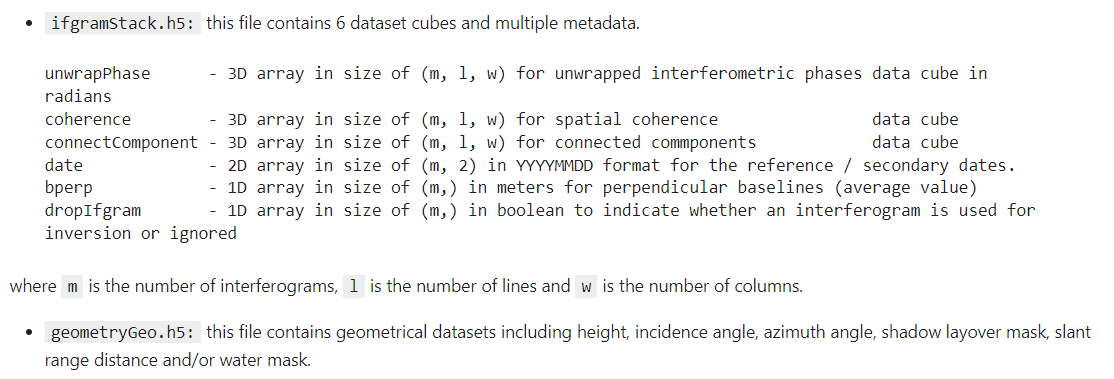

In [ ]:
!info.py inputs/geometryGeo.h5

In [ ]:
!info.py inputs/ifgramStack.h5 --date --num --compact

In [ ]:
view.main('inputs/ifgramStack.h5 20190704_20190728'.split())

In [ ]:
view.main('inputs/geometryGeo.h5'.split())

In [ ]:
plot_network.main('inputs/ifgramStack.h5 -t smallbaselineApp.cfg --figsize 12 4'.split())

## Generate average spatial coherence and masks

In [ ]:
!temporal_average.py ./inputs/ifgramStack.h5 -d coherence -o avgSpatialCoh.h5
view.main('avgSpatialCoh.h5 --noverbose'.split())

In [ ]:
!generate_mask.py inputs/geometryGeo.h5 waterMask --nonzero -o waterMask.h5
!generate_mask.py  inputs/ifgramStack.h5 --nonzero -o maskConnComp.h5 --update

In [ ]:
!smallbaselineApp.py  --work-dir {work_dir} {configName}  --dostep modify_network

In [ ]:
plot_network.main(['inputs/ifgramStack.h5'])

In [ ]:
!smallbaselineApp.py  --work-dir {work_dir} {configName}  --dostep reference_point

In [ ]:
!info.py inputs/ifgramStack.h5 | egrep 'REF_'

In [ ]:
!smallbaselineApp.py  --work-dir {work_dir} {configName}  --dostep quick_overview

 ## Invert network of interferograms for time-series

In [ ]:
!smallbaselineApp.py  --work-dir {work_dir} {configName} --dostep invert_network

In [ ]:
view.main('timeseries.h5 -v -5 5 --noaxis'.split())

In [ ]:
!smallbaselineApp.py  --work-dir {work_dir} {configName} --dostep correct_troposphere

In [ ]:
!smallbaselineApp.py  --work-dir {work_dir} {configName} --dostep correct_topography

In [ ]:
!info.py timeseries.h5 --compact

In [ ]:
!smallbaselineApp.py  --work-dir {work_dir} {configName} --dostep velocity

# Time-series to velocity

In [ ]:
opt = f'--dem inputs/geometryGeo.h5 --shade-exag 0.05 --dem-nocontour  --figsize 10 8'
view.main(f'velocity.h5 velocity {opt}'.split())


# All Step in One 

In [ ]:
!smallbaselineApp.py  --work-dir {work_dir} {configName}

In [ ]:
wget https://zenodo.org/record/11049257/files/RidgecrestSenDT71.tar.xz
tar -xvJf RidgecrestSenDT71.tar.xz